# Библиотеки

In [2]:
!pip install -q implicit
!pip install -q pyarrow
!pip install -q fastparquet

In [3]:
import pandas as pd
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import implicit
import os
import gc
from tqdm import tqdm 
from scipy.sparse import coo_matrix
import sqlite3
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Загрузка данных

Будем работать с player_starts_train и video

In [7]:
pst_df = pd.read_parquet('player_starts_train.parquet', engine='pyarrow')
video_df = pd.read_parquet('videos.parquet', engine='fastparquet')

После загрузки отображаем данные. В player_starts_train более 69 млн записей, в videos - более 2 млн записей

In [9]:
pst_df
video_df

,date,user_id,item_id,watch_time,is_autorized
0,2023-07-21 19:04:50+03:00,user_12964323,video_1042531,51,0
1,2023-07-21 02:02:41+03:00,user_16517,video_1707159,31,0
2,2023-07-21 22:00:47+03:00,user_15057892,video_1989987,9,0
3,2023-07-21 19:09:43+03:00,user_2846972,video_1356486,-1,0
4,2023-07-21 11:06:58+03:00,user_20517034,video_1380654,11,0
...,...,...,...,...,...
69954375,2023-08-21 02:51:53+03:00,user_15478739,video_1449287,291,1
69954376,2023-08-21 08:40:18+03:00,user_25783543,video_1423321,2,0
69954377,2023-08-21 05:19:55+03:00,user_3507470,video_464555,261,0
69954378,2023-08-21 12:32:32+03:00,user_13128840,video_420973,21,0


,item_id,video_title,author_title,tv_title,season,video_description,category_title,publicated,duration,channel_sub,tv_sub,ctr.CTR_10days_21_07,ctr.CTR_10days_01_08,ctr.CTR_10days_10_08,ctr.CTR_10days_21_08
0,video_165654,MSI Pro MP241X недоОБЗОР (РЕШЕНИЕ ПРОБЛЕМЫ С М...,Silvi,None,0,В видео я обывательским взглядом расскажу про ...,Технологии и интернет,2022-12-08 13:53:05+03:00,391382,0,0,NaN,0.0,0.000000,NaN
1,video_1173704,Наложение пястно фаланговой повязки на кисть,"УЦ ""Академия Безопасности""",None,0,Видео с канала УЦ Академия безопасности (ab-dp...,Образование,2022-03-24 09:19:15+03:00,125922,26,0,NaN,0.0,0.000000,0.00
2,video_23927,SilverstoneF1 Sochi Pro и Neoline x cop 6000s ...,Artur48,None,0,SilverstoneF1 Sochi Pro и Neoline x cop 6000s ...,Авто-мото,2022-03-19 17:41:49+03:00,436570,2,0,NaN,NaN,0.000000,0.00
3,video_1003780,БОЛЬНИЦА в Brookhaven! ДОКТОР ПУПКИН спас ЖЕНИ...,ПАПА ДОЧКИ Games,None,0,Играем в Роблокс (Roblox) - БОЛЬНИЦА в Brookha...,Детям,2021-02-20 11:50:53+03:00,719377,673,0,0.0,1.0,0.000000,0.00
4,video_105383,"Вебинар ""Особенности трудоустройства граждан Б...","ЗАО ""Сплайн-Центр""",None,0,"10.08.2023 Вебинар ""Особенности трудоустройств...",Бизнес и предпринимательство,2023-08-11 09:02:07+03:00,3834404,19,0,0.0,0.0,0.000000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2320655,video_839160,Любимцы: Гена в памперсе бегает по клинике,Любимцы,Любимцы,1,None,Сериалы,2017-09-11 22:00:13+03:00,23290,0,0,NaN,0.0,0.333333,0.25
2320656,video_2134427,"Телеканал «СПАС», «Главное», интервью С. В. Ст...",Фонд развития территорий,None,0,None,Интервью,2022-03-28 11:19:33+03:00,1548792,57,0,0.0,0.0,0.000000,0.00
2320657,video_1453482,Взятие 3 отметок на ИС 7,CeperA_TyLyH,None,0,None,Видеоигры,2022-09-10 20:05:17+03:00,520001,12,0,NaN,NaN,NaN,NaN
2320658,video_2225207,Простой и вкусный рецепт пирога с грушами и сы...,Комедийные Шоу и Скетчи ❤,None,0,None,Разное,2023-07-06 12:16:29+03:00,8267,9,0,0.0,0.0,0.000000,0.00


# Работа с данными

In [ ]:
pst_df.isna().sum()

In [10]:
pst_df[pst_df.duplicated(keep=False)]

,date,user_id,item_id,watch_time,is_autorized
1620,2023-07-21 20:04:57+03:00,user_16206290,video_2053251,91,0
1622,2023-07-21 20:04:57+03:00,user_16206290,video_2053251,91,0
2736,2023-07-21 07:01:13+03:00,user_6846705,video_2053251,132,0
2739,2023-07-21 07:01:13+03:00,user_6846705,video_2053251,132,0
4562,2023-07-21 17:34:38+03:00,user_11171041,video_1718825,161,0
...,...,...,...,...,...
69943783,2023-08-21 10:56:54+03:00,user_26584530,video_283933,4591,0
69944714,2023-08-21 04:48:06+03:00,user_20349526,video_1817860,41,0
69944715,2023-08-21 04:48:06+03:00,user_20349526,video_1817860,41,0
69946998,2023-08-21 02:45:39+03:00,user_16604619,video_2132092,252,0


## Создание признака is_watched
Бинарный признак, обозначающий долгий просмотр видео*

*Долгий просмотр определяется так: для видео меньше 5 минут долгим считается просмотр видео с watch_time более 30 секунд, для видео более 5 минут долгим считаем просмотр с watch_time более 25% длительности видео

Уберем записи, где значение watch_time = -1

In [8]:
pst_df_1 = pst_df[pst_df['watch_time'] != -1]

In [9]:
pst_df_1

,date,user_id,item_id,watch_time,is_autorized
0,2023-07-21 19:04:50+03:00,user_12964323,video_1042531,51,0
1,2023-07-21 02:02:41+03:00,user_16517,video_1707159,31,0
2,2023-07-21 22:00:47+03:00,user_15057892,video_1989987,9,0
4,2023-07-21 11:06:58+03:00,user_20517034,video_1380654,11,0
5,2023-07-21 23:24:41+03:00,user_8293675,video_331810,340,0
...,...,...,...,...,...
69954375,2023-08-21 02:51:53+03:00,user_15478739,video_1449287,291,1
69954376,2023-08-21 08:40:18+03:00,user_25783543,video_1423321,2,0
69954377,2023-08-21 05:19:55+03:00,user_3507470,video_464555,261,0
69954378,2023-08-21 12:32:32+03:00,user_13128840,video_420973,21,0


Здесь было принято решение оставить только тех юзеров, у которых было более пяти появлений в таблице,

In [10]:
user_id_counts = pst_df_1.groupby('user_id').size().reset_index(name='count')
selected_user_ids = user_id_counts[user_id_counts['count'] >= 5]['user_id']
pst_df_12 = pst_df_1[pst_df_1['user_id'].isin(selected_user_ids)]

In [11]:
pst_df_12

,date,user_id,item_id,watch_time,is_autorized
2,2023-07-21 22:00:47+03:00,user_15057892,video_1989987,9,0
5,2023-07-21 23:24:41+03:00,user_8293675,video_331810,340,0
8,2023-07-21 04:39:05+03:00,user_11171041,video_1511844,90,0
11,2023-07-21 15:50:50+03:00,user_24696346,video_1448534,12,1
12,2023-07-21 01:16:47+03:00,user_325285,video_523098,1,0
...,...,...,...,...,...
69954374,2023-08-21 16:44:47+03:00,user_11895299,video_853811,101,0
69954375,2023-08-21 02:51:53+03:00,user_15478739,video_1449287,291,1
69954377,2023-08-21 05:19:55+03:00,user_3507470,video_464555,261,0
69954378,2023-08-21 12:32:32+03:00,user_13128840,video_420973,21,0


Соединим таблицы videos и player_starts_train

In [12]:
merged_df = pst_df_1.merge(video_df[['item_id', 'duration']], on='item_id', how='left')


merged_df = merged_df[['user_id', 'item_id', 'duration', 'watch_time', 'is_autorized']]

Умножим watch_time на 1000, чтобы перевести секунды в миллисекунды

In [13]:
merged_df['watch_time'] = merged_df['watch_time'] * 1000

In [14]:
merged_df

,user_id,item_id,duration,watch_time,is_autorized
0,user_12964323,video_1042531,213718,51000,0
1,user_16517,video_1707159,129562,31000,0
2,user_15057892,video_1989987,242006,9000,0
3,user_20517034,video_1380654,15134,11000,0
4,user_8293675,video_331810,343749,340000,0
...,...,...,...,...,...
66376885,user_15478739,video_1449287,19280022,291000,1
66376886,user_25783543,video_1423321,73634,2000,0
66376887,user_3507470,video_464555,264534,261000,0
66376888,user_13128840,video_420973,152555,21000,0


In [15]:
merged_df['watch_time'] = merged_df['watch_time'].astype('float64')

Делаем признак is_watched по дефолту 1, максимум 5 согласно условию, что такое долгий просмотр

In [16]:
merged_df['is_watched'] = 1

merged_df.loc[(merged_df['watch_time'] > 30000) & (merged_df['duration'] <= 300000), 'is_watched'] = 5
merged_df.loc[(merged_df['watch_time'] > (merged_df['duration'] * 0.25)) & (merged_df['duration'] > 300000), 'is_watched'] = 5

merged_df.loc[merged_df['watch_time'] == -1000, 'is_watched'] = 1

In [17]:
merged_df

,user_id,item_id,duration,watch_time,is_autorized,is_watched
0,user_12964323,video_1042531,213718,51000.0,0,5
1,user_16517,video_1707159,129562,31000.0,0,5
2,user_15057892,video_1989987,242006,9000.0,0,1
3,user_20517034,video_1380654,15134,11000.0,0,1
4,user_8293675,video_331810,343749,340000.0,0,5
...,...,...,...,...,...,...
66376885,user_15478739,video_1449287,19280022,291000.0,1,1
66376886,user_25783543,video_1423321,73634,2000.0,0,1
66376887,user_3507470,video_464555,264534,261000.0,0,5
66376888,user_13128840,video_420973,152555,21000.0,0,1


In [ ]:
merged_df.to_csv("merged_df.csv", index=False)

In [ ]:
merged_df = pd.read_csv('merged_df.csv', index=False)

In [18]:
# Группируем по 'user_id' и считаем количество появлений каждого пользователя
user_counts = merged_df.groupby('user_id').size().reset_index(name='count')

min(user_counts['count'])
max(user_counts['count'])

1

63806

In [19]:
user_counts

,user_id,count
0,user_0,1
1,user_1,1
2,user_10,1
3,user_100,1
4,user_1000,1
...,...,...
27582710,user_9999994,1
27582711,user_9999995,1
27582712,user_9999996,1
27582713,user_9999997,1


<Figure size 1000x600 with 0 Axes>

(array([2.7582165e+07, 2.4000000e+02, 1.0000000e+02, 7.1000000e+01,
        4.2000000e+01, 2.8000000e+01, 2.3000000e+01, 1.4000000e+01,
        1.1000000e+01, 4.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 2.0000000e+00, 2.0000000e+00, 5.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 2.0000000e+00]),
 array([1.00000e+00, 1.27710e+03, 2.55320e+03, 3.82930e+03, 5.10540e+03,
        6.38150e+03, 7.65760e+03, 8.93370e+03, 1.02098e+04, 1.14859e+04

Text(0.5, 1.0, 'Распределение и частотность значений')

Text(0.5, 0, 'Значение')

Text(0, 0.5, 'Частотность (логарифмическая шкала)')

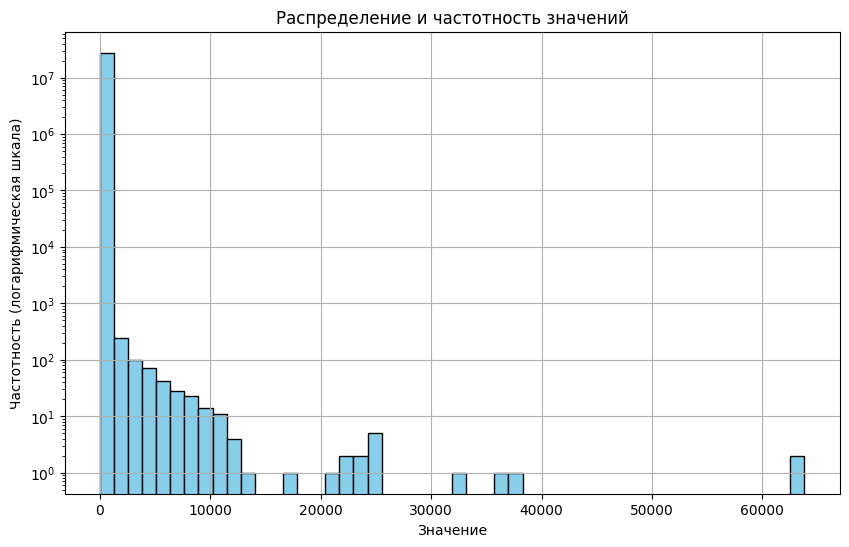

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.figure(figsize=(10, 6))
plt.hist(user_counts['count'], bins=50, color='skyblue', edgecolor='black')
plt.yscale('log') 
plt.title('Распределение и частотность значений')
plt.xlabel('Значение')
plt.ylabel('Частотность (логарифмическая шкала)')
plt.grid(True)

plt.show()


<Figure size 1000x600 with 0 Axes>

(array([2.756732e+07, 1.098800e+04, 2.088000e+03, 8.070000e+02,
        3.810000e+02, 2.270000e+02, 1.420000e+02, 8.900000e+01,
        7.000000e+01, 5.700000e+01, 4.500000e+01, 3.600000e+01,
        3.600000e+01, 2.600000e+01, 2.100000e+01, 2.000000e+01,
        1.300000e+01, 2.000000e+01, 1.400000e+01, 5.000000e+00,
        2.100000e+01, 1.300000e+01, 7.000000e+00, 4.000000e+00,
        1.000000e+01, 1.000000e+01, 4.000000e+00, 1.300000e+01,
        8.000000e+00, 1.200000e+01, 1.100000e+01, 1.500000e+01,
        3.000000e+00, 6.000000e+00, 8.000000e+00, 9.000000e+00,
        6.000000e+00, 6.000000e+00, 2.000000e+00, 5.000000e+00,
        4.000000e+00, 5.000000e+00, 9.000000e+00, 2.000000e+00,
        7.000000e+00, 6.000000e+00, 3.000000e+00, 3.000000e+00,
        1.000000e+00, 1.000000e+00]),
 array([1.00000e+00, 1.30020e+02, 2.59040e+02, 3.88060e+02, 5.17080e+02,
        6.46100e+02, 7.75120e+02, 9.04140e+02, 1.03316e+03, 1.16218e+03,
        1.29120e+03, 1.42022e+03, 1.54924e+03, 1

Text(0.5, 1.0, 'Распределение и частотность значений')

Text(0.5, 0, 'Значение')

Text(0, 0.5, 'Частотность (логарифмическая шкала)')

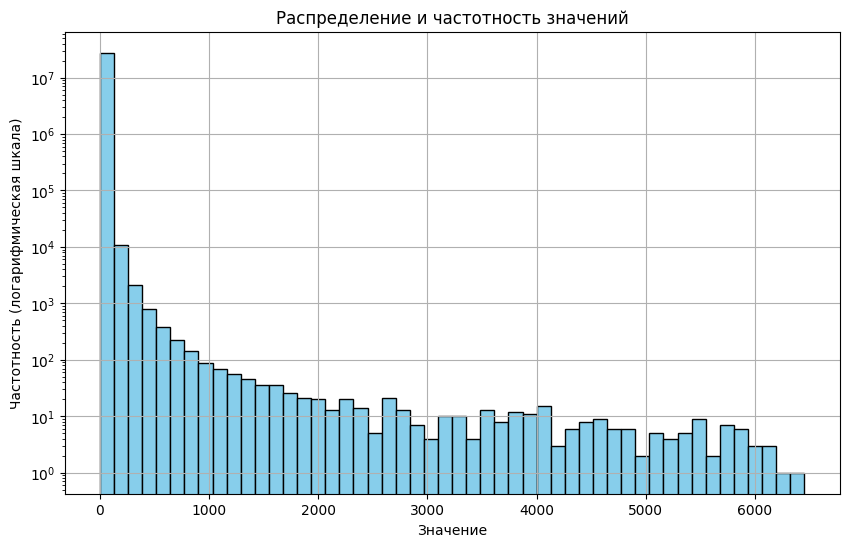

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

filtered_data = user_counts[user_counts['count'] <= 6500]


plt.figure(figsize=(10, 6))
plt.hist(filtered_data['count'], bins=50, color='skyblue', edgecolor='black')
plt.yscale('log')  
plt.title('Распределение и частотность значений')
plt.xlabel('Значение')
plt.ylabel('Частотность (логарифмическая шкала)')
plt.grid(True)

plt.show()


/tmp/ipykernel_32/3429053636.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data = filtered_data[user_counts['count'] >= 4]


<Figure size 1000x600 with 0 Axes>

(array([2.450619e+06, 1.483720e+05, 4.986400e+04, 2.074100e+04,
        1.114100e+04, 6.397000e+03, 4.096000e+03, 2.876000e+03,
        1.872000e+03, 1.397000e+03, 1.021000e+03, 8.250000e+02,
        5.860000e+02, 4.850000e+02, 4.270000e+02, 3.170000e+02,
        2.570000e+02, 2.340000e+02, 2.190000e+02, 1.680000e+02,
        1.510000e+02, 1.470000e+02, 1.180000e+02, 9.400000e+01,
        1.150000e+02, 7.700000e+01, 7.200000e+01, 6.000000e+01,
        5.600000e+01, 7.700000e+01, 5.800000e+01, 3.900000e+01,
        4.200000e+01, 3.800000e+01, 3.300000e+01, 3.600000e+01,
        3.800000e+01, 2.500000e+01, 2.800000e+01, 3.300000e+01,
        1.600000e+01, 1.700000e+01, 1.800000e+01, 1.900000e+01,
        2.400000e+01, 2.500000e+01, 1.200000e+01, 1.500000e+01,
        1.200000e+01, 1.400000e+01]),
 array([   4.  ,   23.92,   43.84,   63.76,   83.68,  103.6 ,  123.52,
         143.44,  163.36,  183.28,  203.2 ,  223.12,  243.04,  262.96,
         282.88,  302.8 ,  322.72,  342.64,  362.56,

Text(0.5, 1.0, 'Распределение и частотность значений')

Text(0.5, 0, 'Значение')

Text(0, 0.5, 'Частотность (логарифмическая шкала)')

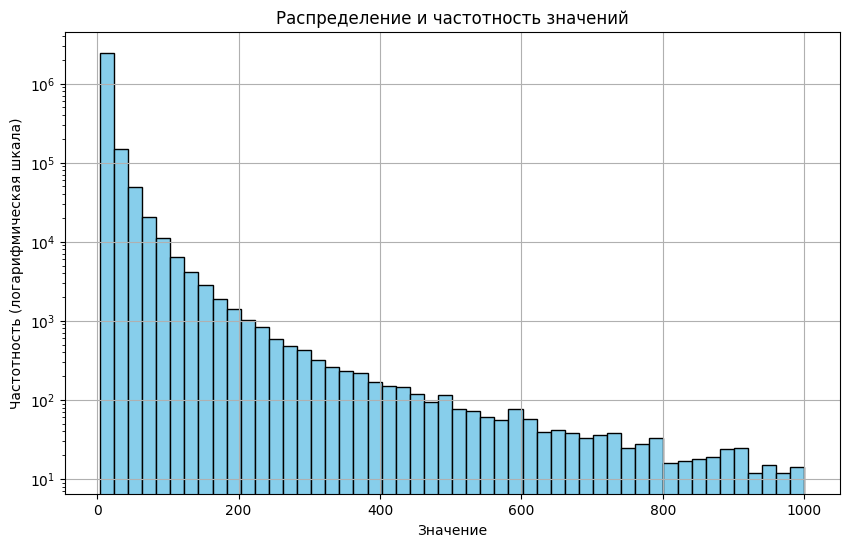

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

filtered_data = user_counts[user_counts['count'] <= 1000]
filtered_data = filtered_data[user_counts['count'] >= 4]



plt.figure(figsize=(10, 6))
plt.hist(filtered_data['count'], bins=50, color='skyblue', edgecolor='black')
plt.yscale('log') 
plt.title('Распределение и частотность значений')
plt.xlabel('Значение')
plt.ylabel('Частотность (логарифмическая шкала)')
plt.grid(True)

plt.show()
